# Libraries

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from trendfilter import trend_filter

# Data

In [2]:
train_events = pd.read_csv("train_events.csv")

In [3]:
series_has_NaN = train_events.groupby('series_id')['step'].apply(lambda x: x.isnull().any())
no_NaN_series = series_has_NaN[~series_has_NaN].index.tolist()
# also drop these two "truncated" events series seen in EDA:
no_NaN_series.remove('31011ade7c0a') # incomplete events data
no_NaN_series.remove('a596ad0b82aa') # incomplete events data

In [4]:
def get_train_series(series):
    train_series = pd.read_parquet("train_series.parquet", filters=[('series_id','=',series)])
    train_events = pd.read_csv("train_events.csv").query('series_id == @series')
    
    train_events = train_events.dropna()
    train_events["step"]  = train_events["step"].astype("int")
    train_events["awake"] = train_events["event"].replace({"onset":1,"wakeup":0})

    train = pd.merge(train_series, train_events[['step','awake']], on='step', how='left')
    train["awake"] = train["awake"].bfill(axis ='rows')
    # final section:
    # train_events.groupby('series_id').tail(1)["event"].unique()
    # Result: the last event is always a "wakeup"
    train['awake'] = train['awake'].fillna(1) # awake
    train["awake"] = train["awake"].astype("int")
    
    # modify timestamp
    train['timestamp'] = pd.to_datetime(train['timestamp'].apply(lambda x: str(x).rsplit('-', 1)[0]))

    return(train)

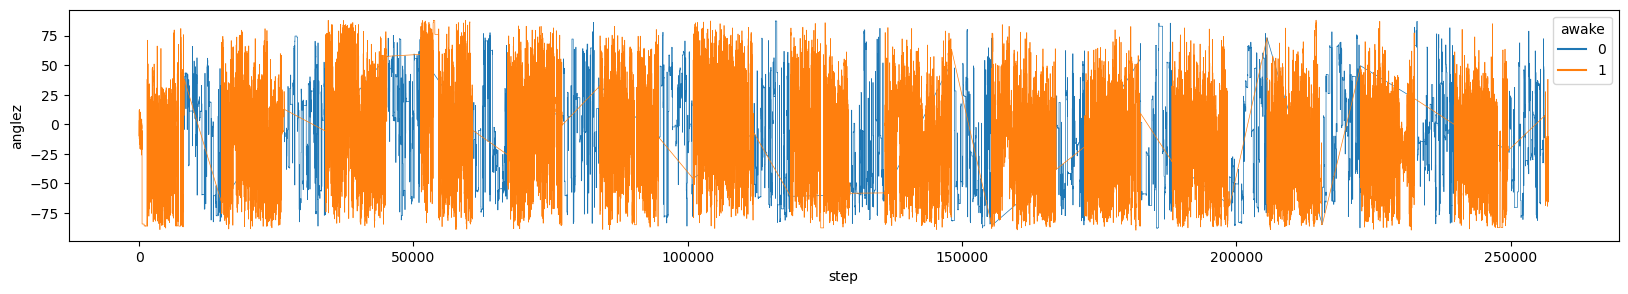

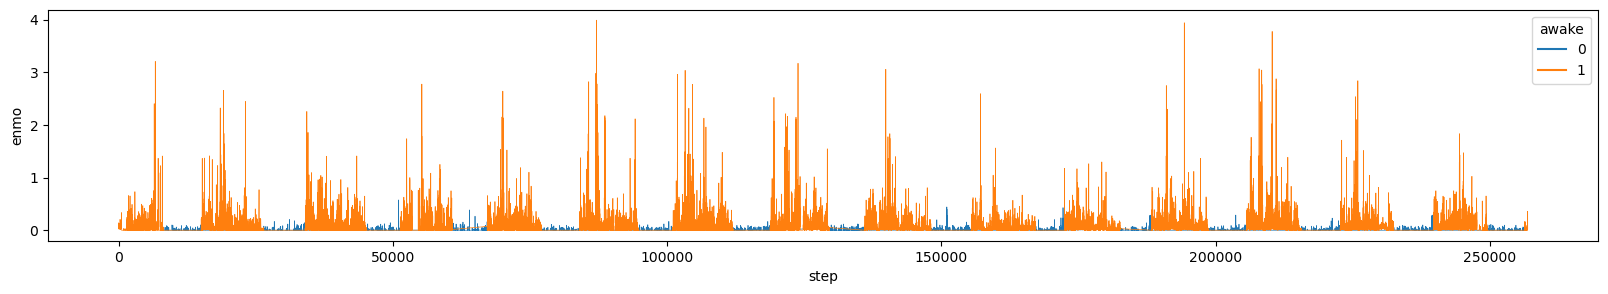

In [5]:
# Focus on data from one subject for now
train = get_train_series(no_NaN_series[1])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=train, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

In [6]:
train

,series_id,step,timestamp,anglez,enmo,awake
0,0a96f4993bd7,0,2018-05-03 10:30:00,3.272400,0.0386,1
1,0a96f4993bd7,1,2018-05-03 10:30:05,0.073100,0.0663,1
2,0a96f4993bd7,2,2018-05-03 10:30:10,-2.456300,0.0408,1
3,0a96f4993bd7,3,2018-05-03 10:30:15,-5.466900,0.0820,1
4,0a96f4993bd7,4,2018-05-03 10:30:20,-10.008800,0.0788,1
...,...,...,...,...,...,...
256855,0a96f4993bd7,256855,2018-05-18 07:14:35,-62.247898,0.0153,1
256856,0a96f4993bd7,256856,2018-05-18 07:14:40,-62.449299,0.0085,1
256857,0a96f4993bd7,256857,2018-05-18 07:14:45,-61.691601,0.0095,1
256858,0a96f4993bd7,256858,2018-05-18 07:14:50,-60.325699,0.0259,1


### Features

In [7]:
def feature_extraction(df, w):
    median_enmo = df.enmo.rolling(w).median()
    median_enmo_before = median_enmo[w:-w] 
    median_enmo_after = median_enmo[(2*w):]

    diff_anglez = pd.Series(np.abs(np.diff(df.anglez, prepend = 0)))
    median_diff_anglez = diff_anglez.rolling(w).median()
    median_diff_anglez_before = median_diff_anglez[w:-w]
    median_diff_anglez_after = median_diff_anglez[(2*w):]

    # Feature matrix 
    X = np.transpose(np.array([median_enmo_before.values, 
                               median_enmo_after.values, 
                               median_diff_anglez_before.values, 
                               median_diff_anglez_after.values,
                              ]
                             )
                    )
    return(X)

### 1) Fit classifier

In [8]:
w = 5
X_train = feature_extraction(train, w)
y_train = train.awake[w:-w]

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [26]:
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
#clf = RandomForestClassifier().fit(X_train, y_train)
print(clf.score(X_train, y_train))
pred = clf.predict(X_train)

0.8824372201674129


In [11]:
print(clf.coef_)

[[3.92146651 3.74643367 1.1058933  1.00352384]]


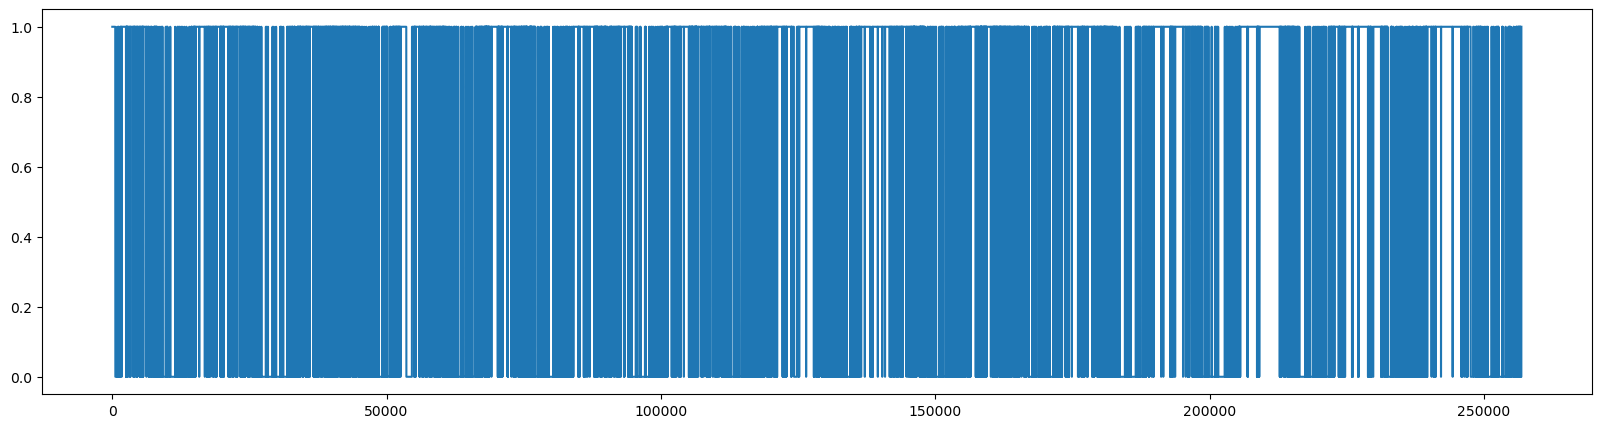

In [48]:
plt.rcParams["figure.figsize"] = (20, 5)
plt.plot(pred)

### 2) Trend filtering

In [12]:
import time

In [13]:
x = np.linspace(0, len(pred), len(pred))

In [14]:
alpha = 250

In [15]:
start_time = time.time()
tf = trend_filter(x, pred, l_norm=1, alpha_1=alpha)
print("--- %s seconds ---" % (time.time() - start_time))

--- 119.1758885383606 seconds ---


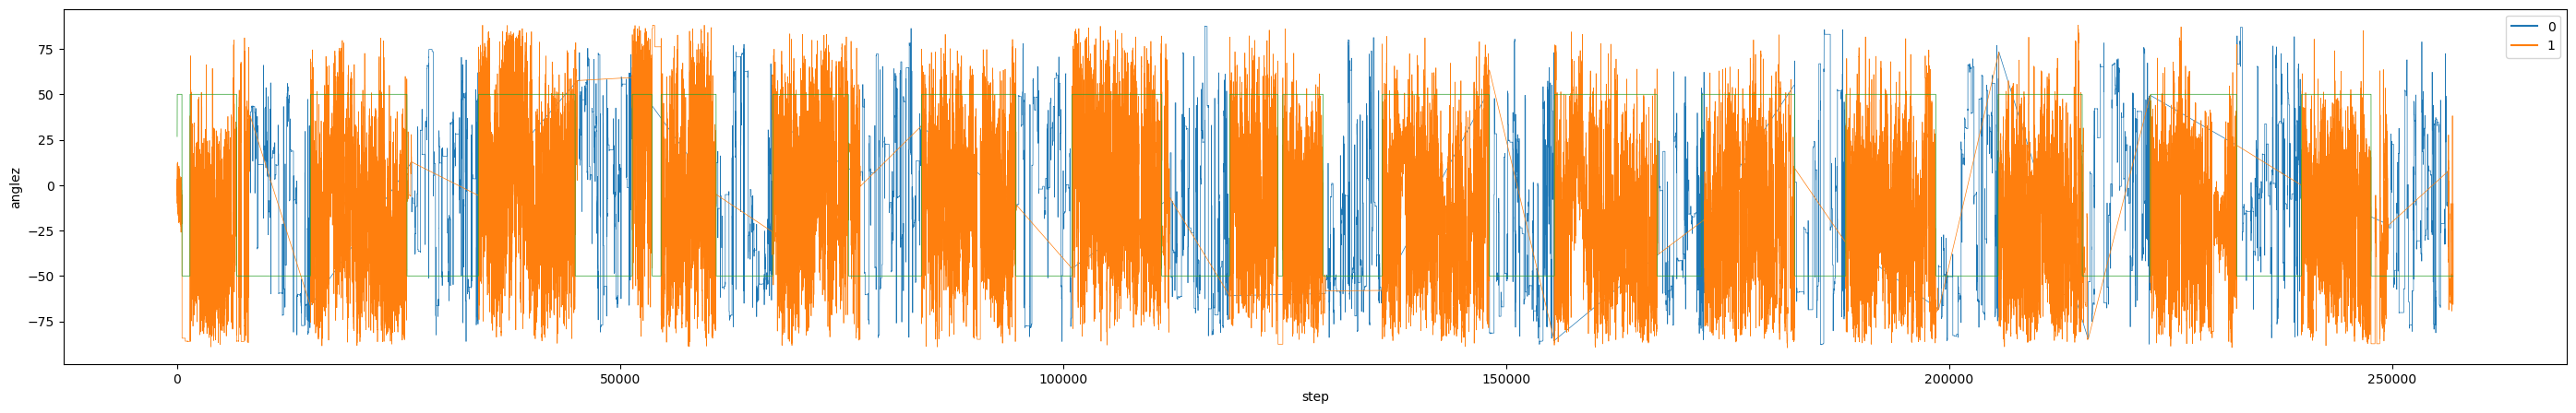

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=train, x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 100 - 50, linewidth = 0.5)
plt.show();

In [ ]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), y_train, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0.0,98468,11655
1.0,424,146303


In [ ]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.9529725520731944

In [ ]:
pred = np.round(tf['y_fit'])
sum(pred[1:] != pred[:-1])

37

In [ ]:
sum(y_train.values[1:] != y_train.values[:-1])

30

In [ ]:
np.where(pred[1:] != pred[:-1])

(array([   536,   1441,   6715,  15045,  25929,  34016,  44906,  51356,
         53585,  54606,  60822,  67210,  75753,  83989,  94636, 100993,
        111089, 118783, 124237, 124772, 129321, 129324, 129332, 135986,
        148061, 155435, 167019, 172074, 182565, 188312, 198475, 205505,
        214997, 222696, 232425, 239730, 247596]),)

In [59]:
np.where(y_train.values[1:] != y_train.values[:-1])

(array([  8251,  15019,  26455,  33967,  45151,  51331,  60811,  67171,
         77095,  83959,  94759, 100975, 112039, 118747, 129583, 135967,
        148087, 155407, 167191, 172387, 182551, 188263, 198799, 205591,
        215671, 222655, 232459, 239707, 249607, 256255]),)

In [34]:
pred = pred[: (midnight[0] + 10000)]

In [38]:
import cvxpy as cp

# Define the optimization variable x
n = len(pred)
x = cp.Variable(n)
z = cp.Variable(n-1)

# Set up the objective function: minimize L2 norm distance from y
objective = cp.Minimize(cp.norm2(x - pred))

# Add constraints: 0 < x_i < 1 for all i
constraints = [0 <= x, x <= 1]

A = np.eye(n, k=1) - np.eye(n)
A = A[:-1, :]

# Add constraint: L2 norm of z is equal to 2
#constraints.append(cp.sum_squares(A@x) == 2)
constraints += [x[i + 1] - x[i] == z[i] for i in range(n - 1)]

# Add constraint: sum of squares of z is equal to 4
constraints.append(cp.sum_squares(z) == 4)


# Formulate the problem and solve it
problem = cp.Problem(objective, constraints)
problem.solve()

# Extract the optimal solution
optimal_x = x.value

print("Optimal x:", optimal_x)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
quad_over_lin(var2311974, 1.0) == 4.0 , because the following subexpressions are not:
|--  quad_over_lin(var2311974, 1.0) == 4.0

In [27]:
# Count the nights in the time series and keep track of the corresponding 'step' values for midnight
mask_midnight = (train.timestamp.dt.hour == 0) & (train.timestamp.dt.minute == 0) & (train.timestamp.dt.second == 0)
midnight = train[mask_midnight]['step'].values
print(midnight)

[  9720  27000  44280  61560  78840  96120 113400 130680 147960 165240
 182520 199800 217080 234360 251640]


In [28]:
pred_fall_asleep_step = np.where(pred[1:] - pred[:-1] == -1)[0]
print('Predicted fall-asleep times:')
print(pred_fall_asleep_step)

true_fall_asleep_step = np.where(y_train.values[1:] - y_train.values[:-1] == -1)[0]
print('True fall-asleep times:')
print(true_fall_asleep_step)

# Compare predicted wakeups with true ones
pred_wakeup_step = np.where(pred[1:] - pred[:-1] == +1)[0]
print('Predicted wakeup times:')
print(pred_wakeup_step)
true_wakeup_step = np.where(y_train.values[1:] - y_train.values[:-1] == 1)[0]
print('True wakeup times:')
print(true_wakeup_step)

Predicted fall-asleep times:
[   536    915   1150 ... 256645 256680 256685]
True fall-asleep times:
[  8251  26455  45151  60811  77095  94759 112039 129583 148087 167191
 182551 198799 215671 232459 249607]
Predicted wakeup times:
[   912   1148   1178 ... 256677 256682 256842]
True wakeup times:
[ 15019  33967  51331  67171  83959 100975 118747 135967 155407 172387
 188263 205591 222655 239707 256255]


In [66]:
### Just one sleep phase per night
### Filter out additional ones
### We only keep longest sleep phase

filtered_pred_fall_asleep_step = pred_fall_asleep_step.copy()
filtered_wakeup_step = pred_wakeup_step.copy()


night_range = 10000  # Steps corresponding to 12 hours
keep_list = []
# Iterate through midnight times
for night_step in midnight:
    valid_steps = np.arange(night_step - night_range, night_step + night_range)

    # Filter valid sleep and wake-up steps based on the valid range
    valid_fall_asleep = pred_fall_asleep_step[np.isin(pred_fall_asleep_step, valid_steps)]
    valid_wakeup = pred_wakeup_step[np.isin(pred_wakeup_step, valid_steps)]

    # Initialize variables to track sleep phase information
    index_valid_fall_asleep = 0
    index_valid_wakeup = 0
    longest_sleep_phase = 0
    current_sleep = None
    current_awake = None

    # Iterate through valid sleep and wake-up steps
    while index_valid_fall_asleep < len(valid_fall_asleep) and index_valid_wakeup < len(valid_wakeup):
        if valid_fall_asleep[index_valid_fall_asleep] < valid_wakeup[index_valid_wakeup]:
            if (valid_wakeup[index_valid_wakeup] - valid_fall_asleep[index_valid_fall_asleep] > longest_sleep_phase):
                current_sleep = valid_fall_asleep[index_valid_fall_asleep]
                current_awake = valid_wakeup[index_valid_wakeup]
                longest_sleep_phase = valid_wakeup[index_valid_wakeup] - valid_fall_asleep[index_valid_fall_asleep]
            index_valid_fall_asleep += 1
        else:
            index_valid_wakeup += 1

    keep_list.append(current_sleep)
    keep_list.append(current_awake)

filtered_pred_fall_asleep_step = [x for x in filtered_pred_fall_asleep_step if x in keep_list]
filtered_pred_wakeup_step = [x for x in filtered_wakeup_step if x in keep_list]

In [67]:
# Compare filtered predicted sleep onsets with true ones
filtered_pred_fall_asleep_step = np.array(filtered_pred_fall_asleep_step)
print('Filtered predicted fall-sleep times:')
print(filtered_pred_fall_asleep_step)
print(len(filtered_pred_fall_asleep_step))
print('True fall-sleep times:')
print(true_fall_asleep_step)

# Compare filtered predicted wakeups with true ones
filtered_pred_wakeup_step = np.array(filtered_pred_wakeup_step)
print('Filtered predicted wakeup times:')
print(filtered_pred_wakeup_step)
print(len(filtered_pred_wakeup_step))
print('True wakeup times:')
print(true_wakeup_step)

Filtered predicted fall-sleep times:
[  6715  25929  44906  60822  75753  94636 111089 129332 148061 167019
 182565 198475 214997 232425]
14
True fall-sleep times:
[  8251  26455  45151  60811  77095  94759 112039 129583 148087 167191
 182551 198799 215671 232459 249607]
Filtered predicted wakeup times:
[ 15045  34016  51356  67210  83989 100993 118783 135986 155435 172074
 188312 205505 222696 239730]
14
True wakeup times:
[ 15019  33967  51331  67171  83959 100975 118747 135967 155407 172387
 188263 205591 222655 239707 256255]


In [75]:
np.repeat('a', len(filtered_pred_wakeup_step))

array(['a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a', 'a',
       'a'], dtype='<U1')

In [70]:
# Naive metric to see how far off are we
sleep_onset_differences = filtered_pred_fall_asleep_step-true_fall_asleep_step[:-1]
print(sleep_onset_differences)

[-1536  -526  -245    11 -1342  -123  -950  -251   -26  -172    14  -324
  -674   -34]
6228


In [71]:
# Naive metric to see how far off are we
wakeup_differences = filtered_pred_wakeup_step-true_wakeup_step[:-1]
print(wakeup_differences)

[  26   49   25   39   30   18   36   19   28 -313   49  -86   41   23]
782


### Predict on test data (another subject)

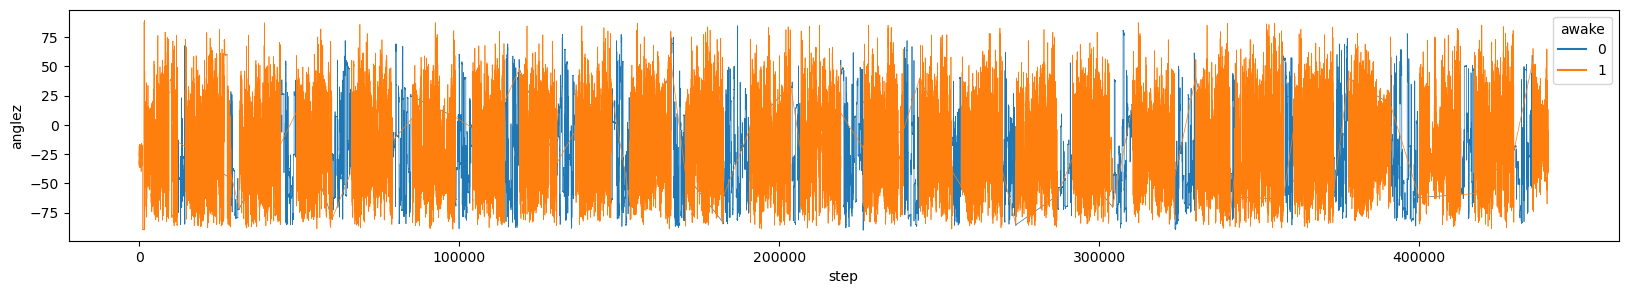

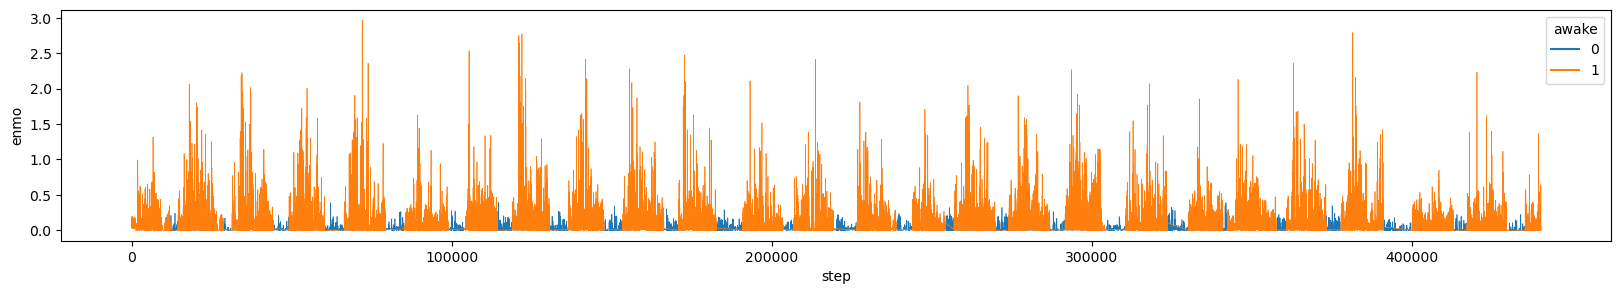

In [56]:
# Focus on data from one subject for now
test = get_train_series(no_NaN_series[0])
    
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=test, x="step", y="anglez",hue="awake", linewidth = 0.5)
plt.show();
fig, ax = plt.subplots(figsize=(20, 3))
sns.lineplot(data=test, x="step", y="enmo",hue="awake", linewidth = 0.5)
plt.show();

Construct features.

In [57]:
median_enmo = test.enmo.rolling(w).median()

In [58]:
y_test = test.awake[w:-w]

In [59]:
median_enmo_before = median_enmo[w:-w]

In [60]:
median_enmo_after = median_enmo[(2*w):]

In [61]:
diff_anglez = pd.Series(np.abs(np.diff(test.anglez, prepend = 0)))
median_diff_anglez = diff_anglez.rolling(w).median()

In [62]:
median_diff_anglez_before = median_diff_anglez[w:-w]

In [63]:
median_diff_anglez_after = median_diff_anglez[(2*w):]

In [64]:
#pd.to_datetime(test['timestamp'].values, format = '%Y-%m-%dT%H:%M:%S%z')

In [65]:
X_test = np.transpose(np.array([median_enmo_before.values, median_enmo_after.values, median_diff_anglez_before.values, median_diff_anglez_after.values]))

Predict with classifier.

In [66]:
pred_test = clf.predict(X_test)

In [67]:
confusion_matrix = pd.crosstab(pred_test, y_test, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0,29060,5469
1,95848,309893


Improve prediction with trend filtering.

In [68]:
x = np.linspace(0, len(pred_test), len(pred_test))

In [73]:
tf = trend_filter(x, pred_test, l_norm=1, alpha_1=250)

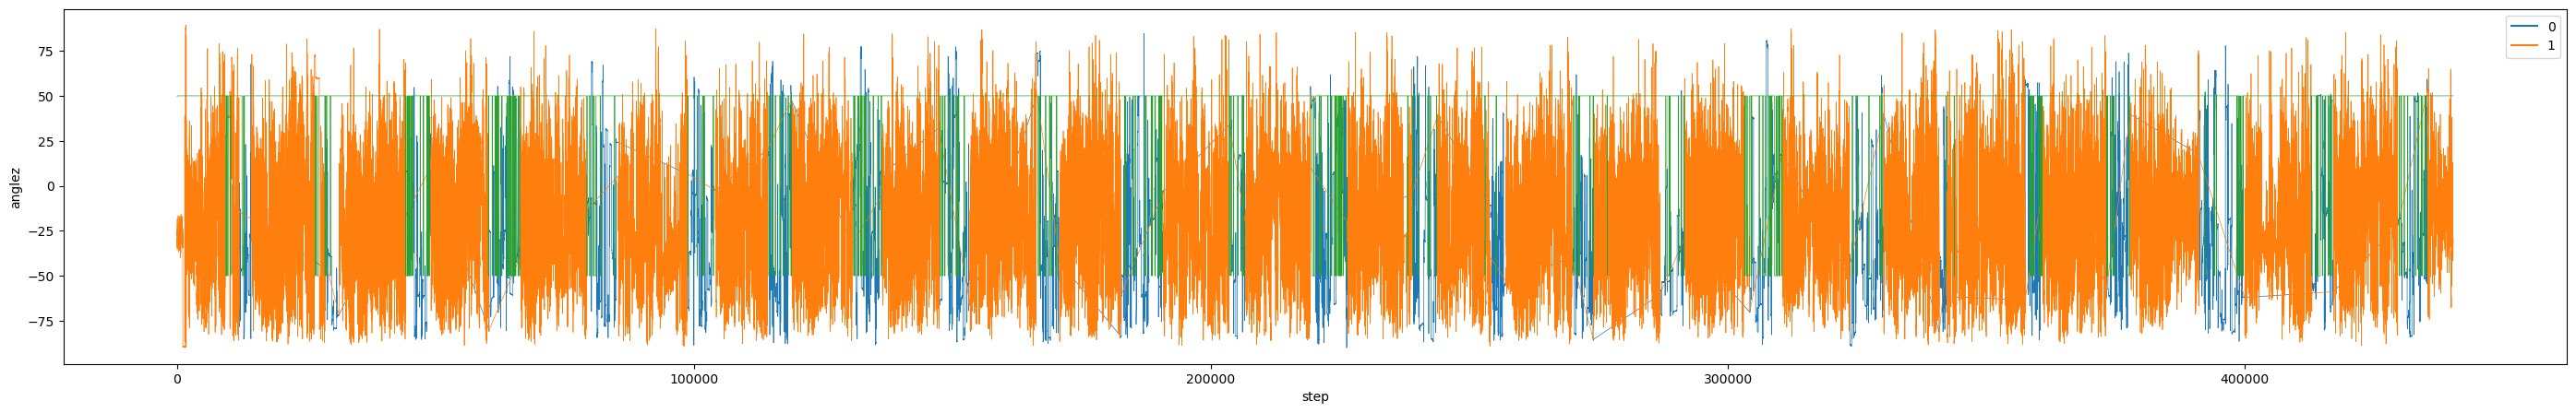

In [ ]:
fig, ax = plt.subplots(figsize=(35, 5))
sns.lineplot(data=test, x="step", y="anglez",hue="awake", linewidth = 0.5)
sns.lineplot(np.append(tf['y_fit'][0], np.round(tf['y_fit'])) * 100 - 50, linewidth = 0.5)
plt.show();

In [ ]:
confusion_matrix = pd.crosstab(np.round(tf['y_fit']), y_test, rownames=['Predicted'], colnames=['Observed'])
confusion_matrix

Observed,0,1
Predicted,,
0.0,14689,1556
1.0,110219,313806


In [77]:
accuracy = (confusion_matrix.iloc[0, 0] + confusion_matrix.iloc[1, 1]) / np.sum(np.sum(confusion_matrix))
accuracy

0.7461216980489245

In [78]:
pred = np.round(tf['y_fit'])
sum(pred[1:] != pred[:-1])

436

In [79]:
sum(y_test.values[1:] != y_test.values[:-1])

50

In [80]:
np.where(pred[1:] != pred[:-1])

(array([  9441,   9487,   9539,   9582,   9754,   9864,  10310,  10366,
         12538,  12741,  12935,  13007,  26672,  26707,  26769,  26804,
         27053,  27324,  28571,  28604,  28836,  28948,  29589,  29708,
         44207,  44241,  44291,  44603,  44636,  44667,  44795,  44900,
         44978,  45124,  45310,  45381,  45519,  45561,  46994,  47043,
         47612,  47671,  48293,  48386,  48446,  48486,  48552,  48602,
         48702,  48830,  60196,  60250,  60920,  60946,  61471,  61536,
         61709,  61763,  61802,  61838,  62008,  62044,  62126,  62164,
         62756,  62858,  63790,  63840,  63923,  64069,  64186,  64281,
         64455,  64552,  64674,  64851,  64924,  64958,  64995,  65031,
         65207,  65249,  65302,  65344,  65412,  65535,  65986,  66019,
         66163,  66321,  79200,  79389,  79771,  79852,  80425,  80513,
         80708,  81016,  81822,  81881,  84594,  84645,  98781,  98827,
        100596, 100628, 101696, 101755, 101885, 102018, 103699, 

In [81]:
np.where(y_test.values[1:] != y_test.values[:-1])

(array([ 11983,  14383,  28675,  31315,  44179,  49123,  60331,  66319,
         79147,  85267,  98815, 104071, 114199, 118831, 130555, 136255,
        147487, 153355, 166171, 170707, 182551, 190867, 203551, 206719,
        219235, 226387, 238807, 243847, 254083, 257071, 269791, 273943,
        286795, 291619, 304183, 310447, 323515, 330115, 340843, 342379,
        357487, 360787, 373171, 377815, 391111, 399955, 412951, 417175,
        429547, 435319]),)

Modify trend filtering to have similar number of change points as ground truth.

In [53]:
#pred_new = pred
#length = test.shape[0]
#x = np.linspace(0, len(pred), len(pred))
#alpha = 250
#
#while ((length * 5)/3600/24 + 1 < sum(pred_new[1:] != pred_new[:-1])):
#    alpha = alpha + 10
#    tf = trend_filter(x, pred, l_norm = 1, alpha_1 = alpha)
#    pred_new = np.round(tf['y_fit'])

SolverError: Solver 'ECOS' failed. Try another solver, or solve with verbose=True for more information.